In [1]:
import os
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
import math
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn.parallel import DataParallel

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
    device = torch.device("cuda")  # Select GPU device
else:
    print("CUDA is not available. Training on CPU.")
    device = torch.device("cpu")   # Fall back to CPU

CUDA is available. Training on GPU.


In [3]:
# Load data
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers

    df_list = []
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_list.append({
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": " ".join(filtered_sent[0:])
        })
    df_ = pd.DataFrame(df_list)
    return df_

# get data, pre-process and split
try:
    data = pd.read_csv("/kaggle/input/amazon/amazon_cells_labelled.txt", delimiter='\t', header=None)
except:
    data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)
    
data.columns = ['Sentence', 'Class']
data['index'] = data.index                                          # add new column index
columns = ['index', 'Class', 'Sentence']
data = preprocess_pandas(data, columns)                             # pre-process
training_data, val_data, training_labels, val_labels = train_test_split( # split the data into training, validation, and test splits
    data['Sentence'].values.astype('U'),
    data['Class'].values.astype('int32'),
    test_size=0.30,
    random_state=0,
    shuffle=True
)

validation_data, test_data, validation_labels, test_labels = train_test_split(val_data, val_labels,test_size=0.50, random_state=0, shuffle=True)


# vectorize data using TFIDF and transform for PyTorch for scalability
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix
training_data = training_data.todense()                             # convert to dense matrix for Pytorch
vocab_size = len(word_vectorizer.vocabulary_)
validation_data = word_vectorizer.transform(validation_data)
validation_data = validation_data.todense()
test_data = word_vectorizer.transform(test_data)
test_data = test_data.todense()
train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()
test_x_tensor = torch.from_numpy(np.array(test_data)).type(torch.FloatTensor)
test_y_tensor = torch.from_numpy(np.array(test_labels)).long()

train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
validation_dataset = TensorDataset(validation_x_tensor, validation_y_tensor)
test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

batch_size = 32

# Create DataLoader for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size,num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size,num_workers=4)

In [4]:
class Chatbot(nn.Module):
    def __init__(self, input_size, hidden_size,num_layers,output_size,dropout=0.2):
        super(Chatbot,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,dropout=dropout,batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size,out_features=output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        x = x.unsqueeze(1)
        out, _ = self.lstm(x, (h0, c0))  # Forward pass through LSTM
        out = self.fc(out[:, -1, :])  # Take the last output and pass it through a linear layer
        out = self.sigmoid(out)  # Apply sigmoid activation
        return out

class ChatbotSimple(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ChatbotSimple, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.long()
        embedded = self.embedding(x)
        embedded_avg = torch.mean(embedded, dim=1)  # Average pooling over the sequence dimension
        output = self.fc(embedded_avg)
        return output

class TransformerModel(nn.Module):
    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.2, num_classes: int = 2):
        super().__init__()
        self.embedding = nn.Embedding(ntoken, d_model)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead, d_hid, dropout),
            nlayers
        )
        self.linear = nn.Linear(d_model, num_classes)

    def forward(self, src: Tensor, src_mask: Tensor = None) -> Tensor:
        src = src.long()
        src = self.embedding(src) * math.sqrt(self.embedding.embedding_dim)
        src = src.transpose(0, 1)
        output = self.transformer_encoder(src, src_mask)
        output = output.transpose(0, 1)
        output = self.linear(output)
        return output

In [5]:
# Train model
def train_model(model,criterion,optimizer,num_epochs,train_loader,validation_loader,device, model_name,num_classes: int = 2):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_sd = None
    model.to(device)
    # Training loop
    for epoch in range(1, num_epochs + 1):
        model.train()  # Set the model to training mode

        for inputs,labels in train_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          labels_one_hot = F.one_hot(labels, num_classes=num_classes).long()   
          if 'lstm' in model_name or 'simple_bot'in model_name:
              labels_one_hot = F.one_hot(labels, num_classes=num_classes).float()
          optimizer.zero_grad()  # Zero the gradients
          outputs = model(inputs)  # Forward pass
          loss = criterion(outputs,labels_one_hot)
          loss.backward()  # Backward pass
          optimizer.step()  # Update weights

        # Validation loop
        model.eval()  # Set the model to evaluation mode

        with torch.no_grad():
            for inputs, labels in validation_loader:
              inputs = inputs.to(device)
              labels = labels.to(device)
              labels_one_hot = F.one_hot(labels, num_classes=num_classes).long()
              if 'lstm' in model_name or 'simple_bot'in model_name:
                  labels_one_hot = F.one_hot(labels, num_classes=num_classes).float()
              outputs = model(inputs)  # Forward pass
              val_loss = criterion(outputs,labels_one_hot)
              

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

        # Save the model with the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_sd = copy.deepcopy(model.state_dict())
        
        # Empty CUDA cache to release GPU memory
        #torch.cuda.empty_cache()
        
    model.load_state_dict(best_model_sd)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    torch.save(model.state_dict(), model_name)

In [6]:
# Test model
def test_model(model, test_loader, device, model_name,num_classes: int = 2):
    classes = ['positive', 'negative']

    y_true = []
    y_pred = []
    correct = 0
    total = 0

    model.load_state_dict(torch.load(model_name))
    model.to(device)
    model.eval()

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        labels_one_hot = F.one_hot(labels, num_classes=num_classes).float()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        _, labels_indices = labels_one_hot.max(dim=1)
        if predicted.size() == labels_indices.size():
            correct += (predicted == labels_indices).sum().item()
        else:
            correct += (predicted == labels_indices.unsqueeze(1)).sum().item()
    

    y_true_indices = convert_to_indices(y_true)
    y_pred_indices = convert_to_indices(y_pred)

    print(f'Test accuracy of the network: {100 * correct // total} %')
    cm = confusion_matrix(y_true_indices, y_pred_indices)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def convert_to_indices(label_list):
    indices = []
    for label in label_list:
        if isinstance(label, np.ndarray):
            index = np.argmax(label)
        elif isinstance(label, torch.Tensor):
            index = torch.argmax(label).item()
        else:
            index = label  # Assume it's already an index
        indices.append(index)
    return indices

In [7]:
epochs = 300
input_size = vocab_size  # Size of vocabulary
hidden_size = 256  # Size of hidden layer
output_size = 2  # Size of vocabulary (for response)
num_layers = 2
model_name_lstm = 'lstm_bot.pth'
model_lstm = Chatbot(input_size=input_size, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)

Using 2 GPUs!
Epoch 10/300, Training Loss: 0.6739, Validation Loss: 0.6865
Epoch 20/300, Training Loss: 0.2714, Validation Loss: 0.4766
Epoch 30/300, Training Loss: 0.0474, Validation Loss: 0.3028
Epoch 40/300, Training Loss: 0.0126, Validation Loss: 0.2688
Epoch 50/300, Training Loss: 0.0043, Validation Loss: 0.2663
Epoch 60/300, Training Loss: 0.0034, Validation Loss: 0.2602
Epoch 70/300, Training Loss: 0.0265, Validation Loss: 0.2654
Epoch 80/300, Training Loss: 0.0012, Validation Loss: 0.2620
Epoch 90/300, Training Loss: 0.0397, Validation Loss: 0.2615
Epoch 100/300, Training Loss: 0.0004, Validation Loss: 0.2603
Epoch 110/300, Training Loss: 0.0004, Validation Loss: 0.2666
Epoch 120/300, Training Loss: 0.0005, Validation Loss: 0.2647
Epoch 130/300, Training Loss: 0.0011, Validation Loss: 0.2638
Epoch 140/300, Training Loss: 0.0003, Validation Loss: 0.2566
Epoch 150/300, Training Loss: 0.0002, Validation Loss: 0.2673
Epoch 160/300, Training Loss: 0.0001, Validation Loss: 0.2618
Epo

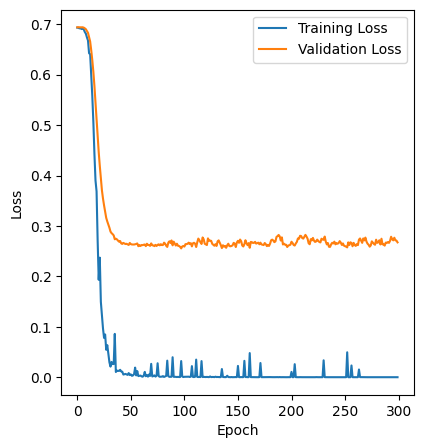

In [8]:
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model_lstm = DataParallel(model_lstm)

criterion = nn.BCELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.0001)

train_model(model=model_lstm, criterion=criterion, optimizer=optimizer, train_loader=train_loader,
                                 validation_loader=validation_loader, num_epochs=epochs, device=device,
                                 model_name=model_name_lstm)

Test accuracy of the network: 80 %


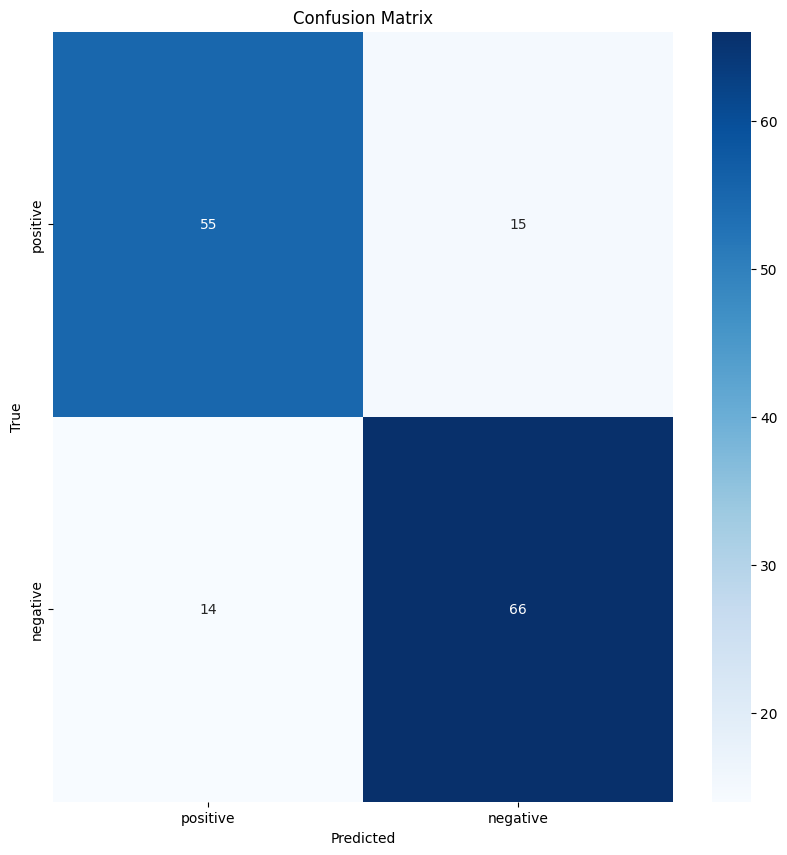

In [9]:
test_model(model=model_lstm,test_loader=test_loader,device=device,model_name=model_name_lstm)

In [10]:
epochs = 300
input_size = vocab_size  # Size of vocabulary
hidden_size = 256  # Size of hidden layer
output_size = 2  # Size of vocabulary (for response)
num_layers = 2
model_name_simple_bot = 'simple_bot.pth'
model_simple_bot = ChatbotSimple(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

Using 2 GPUs!
Epoch 10/300, Training Loss: 0.7069, Validation Loss: 0.6870
Epoch 20/300, Training Loss: 0.6883, Validation Loss: 0.7013
Epoch 30/300, Training Loss: 0.6955, Validation Loss: 0.6995
Epoch 40/300, Training Loss: 0.6942, Validation Loss: 0.6951
Epoch 50/300, Training Loss: 0.6883, Validation Loss: 0.7051
Epoch 60/300, Training Loss: 0.6931, Validation Loss: 0.6922
Epoch 70/300, Training Loss: 0.6931, Validation Loss: 0.6928
Epoch 80/300, Training Loss: 0.6982, Validation Loss: 0.6864
Epoch 90/300, Training Loss: 0.6935, Validation Loss: 0.6931
Epoch 100/300, Training Loss: 0.6930, Validation Loss: 0.6924
Epoch 110/300, Training Loss: 0.6975, Validation Loss: 0.7011
Epoch 120/300, Training Loss: 0.6963, Validation Loss: 0.6990
Epoch 130/300, Training Loss: 0.6943, Validation Loss: 0.7072
Epoch 140/300, Training Loss: 0.6927, Validation Loss: 0.6935
Epoch 150/300, Training Loss: 0.6904, Validation Loss: 0.6971
Epoch 160/300, Training Loss: 0.6933, Validation Loss: 0.6972
Epo

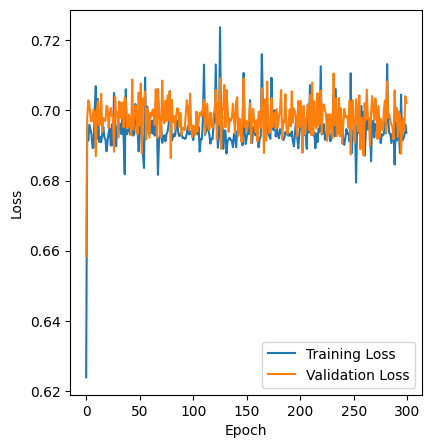

In [11]:
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model_simple_bot = DataParallel(model_simple_bot)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_simple_bot.parameters(),lr=0.0001)

trained_model_emb = train_model(model=model_simple_bot,criterion=criterion,optimizer=optimizer,train_loader=train_loader,validation_loader=validation_loader,num_epochs=epochs,device=device,model_name=model_name_simple_bot)


Test accuracy of the network: 53 %


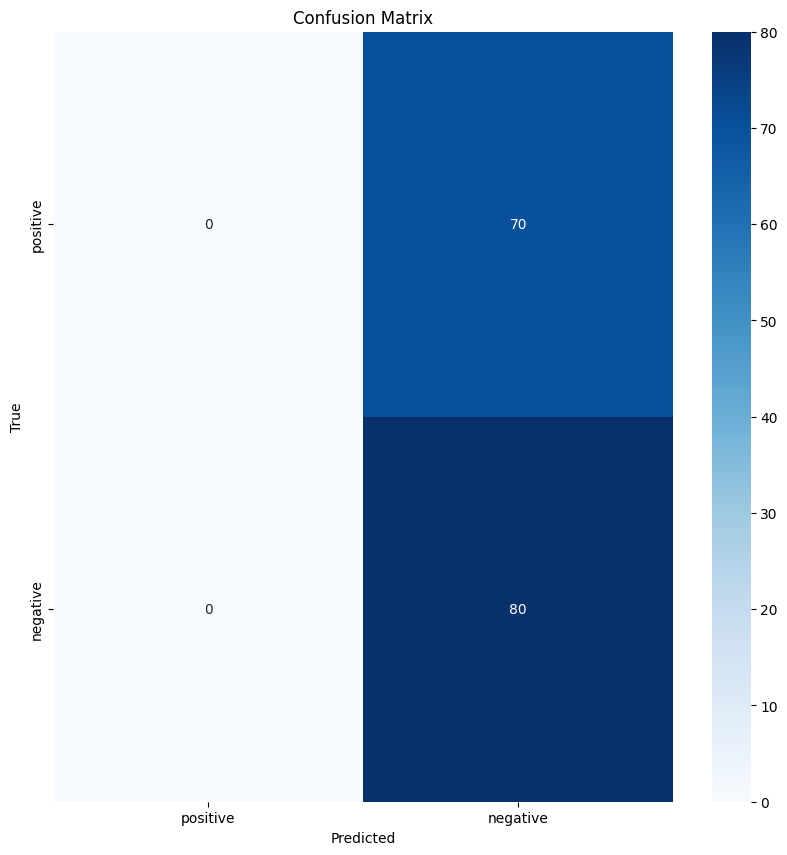

In [12]:
test_model(model=model_simple_bot,test_loader=test_loader,device=device,model_name=model_name_simple_bot)

In [13]:
epochs = 200
ntokens = vocab_size  # size of vocabulary
emsize = 2  # embedding dimension
d_hid = 1  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 1  # number of heads in ``nn.MultiheadAttention``
dropout = 0.5  # dropout probability
model_name_transformer = 'transformer_bot.pth'
model_transformer = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Using 2 GPUs!
Epoch 10/200, Training Loss: 8.3236, Validation Loss: 8.3236
Epoch 20/200, Training Loss: 8.3236, Validation Loss: 8.3236
Epoch 30/200, Training Loss: 8.3236, Validation Loss: 8.3236
Epoch 40/200, Training Loss: 8.3236, Validation Loss: 8.3236
Epoch 50/200, Training Loss: 8.3236, Validation Loss: 8.3236
Epoch 60/200, Training Loss: 8.3236, Validation Loss: 8.3236
Epoch 70/200, Training Loss: 8.3236, Validation Loss: 8.3236
Epoch 80/200, Training Loss: 8.3237, Validation Loss: 8.3236
Epoch 90/200, Training Loss: 8.3236, Validation Loss: 8.3236
Epoch 100/200, Training Loss: 8.3236, Validation Loss: 8.3236
Epoch 110/200, Training Loss: 8.3236, Validation Loss: 8.3236
Epoch 120/200, Training Loss: 8.3236, Validation Loss: 8.3236
Epoch 130/200, Training Loss: 8.3236, Validation Loss: 8.3236
Epoch 140/200, Training Loss: 8.3236, Validation Loss: 8.3236
Epoch 150/200, Training Loss: 8.3236, Validation Loss: 8.3236
Epoch 160/200, Training Loss: 8.3236, Validation Loss: 8.3236
Epo

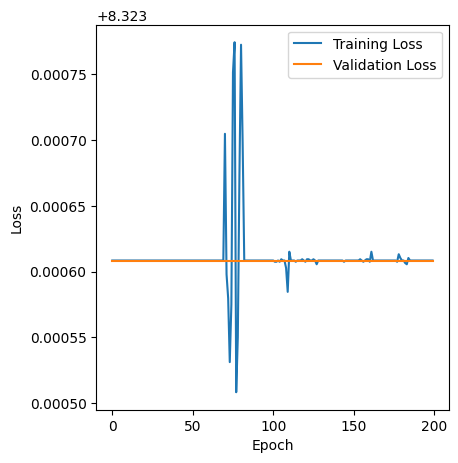

In [14]:
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model_transformer = DataParallel(model_transformer)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_transformer.parameters(), lr=0.001,weight_decay=0.001)

train_model(model=model_transformer,criterion=criterion,optimizer=optimizer,train_loader=train_loader,validation_loader=validation_loader,num_epochs=epochs,device=device,model_name=model_name_transformer)

Test accuracy of the network: 93 %


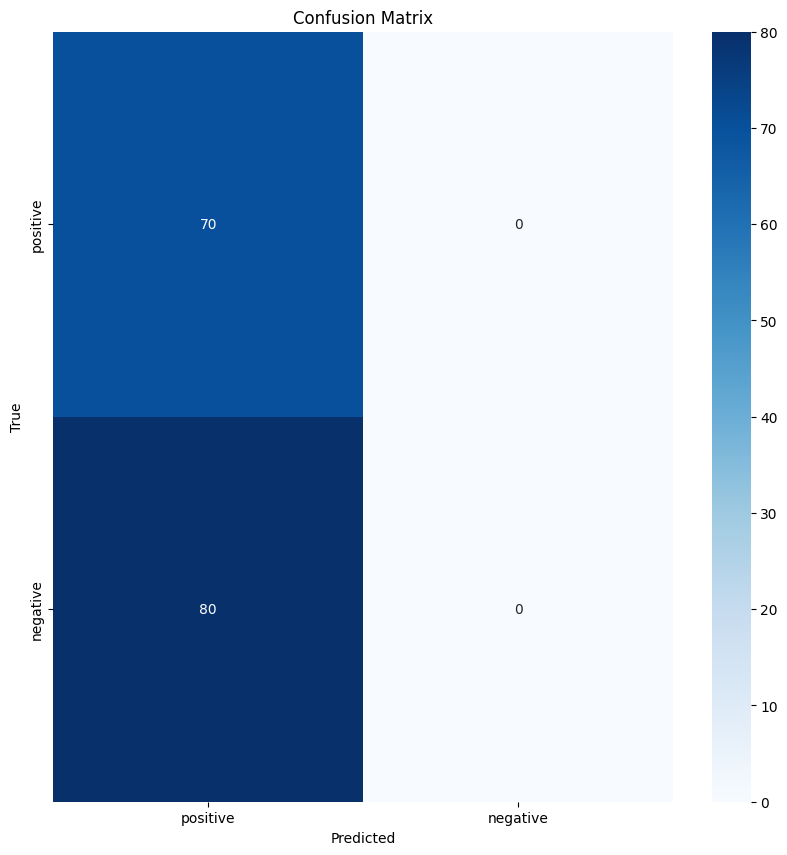

In [15]:
test_model(model=model_transformer,test_loader=test_loader,device=device,model_name=model_name_transformer)

In [28]:
def analyze_sentiment(text, model_lstm, model_transformer, model_name_lstm, model_name_transformer):
    text = word_vectorizer.transform([text])
    text = text.todense()  # convert to dense matrix for Pytorch
    text_tensor_ltsm = torch.from_numpy(np.array(text)).type(torch.FloatTensor)
    text_tensor_transformer = torch.from_numpy(np.array(text)).type(torch.LongTensor)

    model_lstm.load_state_dict(torch.load(model_name_lstm))
    model_lstm.to(device)
    model_lstm.eval()

    model_transformer.load_state_dict(torch.load(model_name_transformer))
    model_transformer.to(device)
    model_transformer.eval()
    
    sentiment2, sentiment1 = None,None
    
    with torch.no_grad():
        output = model_lstm(text_tensor_ltsm)
        _, predicted = torch.max(output, 1)
        sentiment2 = "positive" if predicted.item() == 1 else "negative"
    
    with torch.no_grad():
        output_tr = model_transformer(text_tensor_transformer)
        output_tr = output_tr.view(-1)
        _, predicted_tr = torch.max(output_tr, 0)
        sentiment1 = "positive" if predicted_tr.item() == 1 else "negative"

    

    return f"LTSM - {sentiment2}, Transformer - {sentiment1}"

In [30]:
print("Welcome to the Sentiment Analysis Chatbot!")
while True:
    user_input = input("Please enter your review: ")
    if user_input.lower() == "exit" or user_input == "":
        print("Exiting the chatbot.")
        break
    else:

        sentiment = analyze_sentiment(user_input, model_lstm, model_transformer, model_name_lstm, model_name_transformer)
        print(f"The sentiment of your review is {sentiment}.\n")

Welcome to the Sentiment Analysis Chatbot!


Please enter your review:  The delivery was delayed, but the product itself is fantastic.


The sentiment of your review is LTSM - positive, Transformer - positive.



Please enter your review:  Impressive performance, handles multitasking effortlessly.


The sentiment of your review is LTSM - negative, Transformer - positive.



Please enter your review:  Absolute garbage, wouldn't recommend this product to my worst enemy


The sentiment of your review is LTSM - negative, Transformer - positive.



Please enter your review:  Overpriced for the poor quality, expected better for the price


The sentiment of your review is LTSM - negative, Transformer - positive.



Please enter your review:  Avoid at all costs, this product is a total disaster.


The sentiment of your review is LTSM - negative, Transformer - positive.



Please enter your review:  The delivery was delayed, but the product itself is fantastic


The sentiment of your review is LTSM - positive, Transformer - positive.



Please enter your review:  he customer service was unresponsive and unhelpful when I encountered an issue


The sentiment of your review is LTSM - negative, Transformer - positive.



Please enter your review:  The packaging was damaged upon arrival, but luckily the product itself was unharmed.


The sentiment of your review is LTSM - negative, Transformer - positive.



Please enter your review:  exit


Exiting the chatbot.
